# **Recommendation System 1**

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import tensorflow_recommenders as tfrs

# Load the dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Preprocess the ratings to get unique user IDs
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

# Preprocess the movies to get movie titles
movies = movies.map(lambda x: x["movie_title"])

# Convert the datasets to a unique list of movie titles and user IDs
unique_movie_titles = [movie.numpy().decode('utf-8') for movie in movies]
unique_user_ids = [rating['user_id'].numpy().decode('utf-8') for rating in ratings]

# Remove duplicates
unique_movie_titles = list(set(unique_movie_titles))
unique_user_ids = list(set(unique_user_ids))

print("Unique movie titles:", unique_movie_titles[:5])  # Show a few examples
print("Unique user IDs:", unique_user_ids[:5])          # Show a few examples

# Ensure the lengths are correct
print(f"Number of unique movie titles: {len(unique_movie_titles)}")
print(f"Number of unique user IDs: {len(unique_user_ids)}")

# Set up embeddings
embedding_dimension = 32

# Create user and movie models
user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

# Set up the retrieval task
task = tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128).map(movie_model)
    )
)

# Create the model class
class MovielensModel(tfrs.Model):

    def __init__(self, user_model, movie_model, task):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: dict, training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, positive_movie_embeddings)

model = MovielensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Shuffle and split the data into training and testing sets
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

# Batch and cache the data
cached_train = train.batch(8192).cache()
cached_test = test.batch(4096).cache()

# Train the model
model.fit(cached_train, epochs=10)

# Evaluate the model on the test set
results = model.evaluate(cached_test, return_dict=True)

# Print evaluation results
print(f"Evaluation results: {results}")

def get_movie_recommendations(user_id, model, movie_titles, top_k=10):
    user_embedding = model.user_model(tf.constant([user_id]))
    movie_embeddings = model.movie_model(tf.constant(movie_titles))

    scores = tf.matmul(user_embedding, movie_embeddings, transpose_b=True).numpy().flatten()
    top_indices = np.argsort(scores)[-top_k:][::-1]
    return [movie_titles[i] for i in top_indices]

# Example: Get recommendations for a specific user ID
user_id_example = "42"  # Replace with a valid user ID from your data
recommended_movies = get_movie_recommendations(user_id_example, model, unique_movie_titles)

# Print the recommendations
print(f"Recommended Movies for User ID {user_id_example}:")
for idx, movie in enumerate(recommended_movies, 1):
    print(f"{idx}. {movie}")

def recommend_based_on_preferences(user_id, ratings_data, model, movie_titles, top_k=10):
    rated_movies = [rating['movie_title'].numpy().decode('utf-8') for rating in ratings_data if rating['user_id'].numpy().decode('utf-8') == user_id]
    movie_candidates = [movie for movie in movie_titles if movie not in rated_movies]

    recommended_movies = get_movie_recommendations(user_id, model, movie_candidates, top_k)
    return recommended_movies

# Example: Recommend movies for a user based on past interactions
user_id_preferences_example = "42"  # Replace with a valid user ID
preferences_based_recommendations = recommend_based_on_preferences(user_id_preferences_example, ratings, model, unique_movie_titles)

# Print the recommendations based on user preferences
print(f"Recommendations for User ID {user_id_preferences_example} based on past interactions:")
for idx, movie in enumerate(preferences_based_recommendations, 1):
    print(f"{idx}. {movie}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 1.2 MB/s eta 0:00:00


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/incomplete.B85AWI_0.1.1/movielens-train.tfrecord*..…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/incomplete.6EUNJA_0.1.1/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.
Unique movie titles: ['Crude Oasis, The (1995)', 'First Kid (1996)', 'Jimmy Hollywood (1994)', "Margaret's Museum (1995)", "Gridlock'd (1997)"]
Unique user IDs: ['91', '443', '907', '623', '142']
Number of unique movie titles: 1664
Number of unique user IDs: 943
Epoch 1/10
10/10 [==============================] - 36s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_accuracy: 0.0083 - factorized_top_k/top_10_categorical_accuracy: 0.0193 - factorized_top_k/top_50_categorical_accuracy: 0.0982 - factorized_top_k/top_100_categorical_accuracy: 0.1744 - loss: 69846.1832 - regularization_loss: 0.0000e+00 - total_loss: 69846.1832
Epoch 2/10
10/10 [==============================] - 32s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0027 - factorized_top_k/top_5_categorical_accuracy: 0.0184 - factoriz

# **Recommendation System 2**

Unique movie titles: ['Crude Oasis, The (1995)', 'First Kid (1996)', 'Jimmy Hollywood (1994)', "Margaret's Museum (1995)", "Gridlock'd (1997)"]
Unique user IDs: ['91', '443', '907', '623', '142']
Number of unique movie titles: 1664
Number of unique user IDs: 943
Epoch 1/10
10/10 [==============================] - 49s 5s/step - factorized_top_k/top_1_categorical_accuracy: 9.2500e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0092 - factorized_top_k/top_10_categorical_accuracy: 0.0200 - factorized_top_k/top_50_categorical_accuracy: 0.0985 - factorized_top_k/top_100_categorical_accuracy: 0.1752 - loss: 69841.8523 - regularization_loss: 0.0000e+00 - total_loss: 69841.8523 - val_factorized_top_k/top_1_categorical_accuracy: 0.0028 - val_factorized_top_k/top_5_categorical_accuracy: 0.0147 - val_factorized_top_k/top_10_categorical_accuracy: 0.0316 - val_factorized_top_k/top_50_categorical_accuracy: 0.1532 - val_factorized_top_k/top_100_categorical_accuracy: 0.2694 - val_loss: 28843.0859 

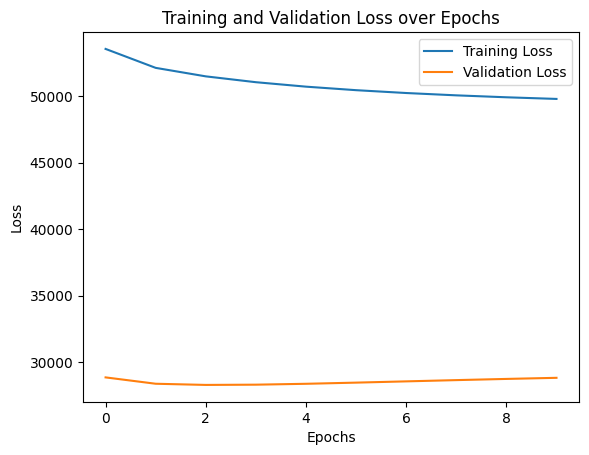

Recommended Movies for User ID 42:
1. Aristocats, The (1970)
2. Jack (1996)
3. Unstrung Heroes (1995)
4. Two if by Sea (1996)
5. Affair to Remember, An (1957)
6. Robin Hood: Prince of Thieves (1991)
7. Rudy (1993)
8. Mr. Wrong (1996)
9. Forget Paris (1995)
10. Bridges of Madison County, The (1995)
Recommendations for User ID 42 based on past interactions:
1. Affair to Remember, An (1957)
2. Mr. Wrong (1996)
3. My Family (1995)
4. Christmas Carol, A (1938)
5. Faithful (1996)
6. Jungle Book, The (1994)
7. Mirror Has Two Faces, The (1996)
8. Don Juan DeMarco (1995)
9. Live Nude Girls (1995)
10. Miracle on 34th Street (1994)


In [ ]:
# Install required libraries
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q matplotlib

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt

# Load the dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Preprocess the ratings to get unique user IDs
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

# Preprocess the movies to get movie titles
movies = movies.map(lambda x: x["movie_title"])

# Convert the datasets to a unique list of movie titles and user IDs
unique_movie_titles = [movie.numpy().decode('utf-8') for movie in movies]
unique_user_ids = [rating['user_id'].numpy().decode('utf-8') for rating in ratings]

# Remove duplicates
unique_movie_titles = list(set(unique_movie_titles))
unique_user_ids = list(set(unique_user_ids))

print("Unique movie titles:", unique_movie_titles[:5])  # Show a few examples
print("Unique user IDs:", unique_user_ids[:5])          # Show a few examples

# Ensure the lengths are correct
print(f"Number of unique movie titles: {len(unique_movie_titles)}")
print(f"Number of unique user IDs: {len(unique_user_ids)}")

# Set up embeddings
embedding_dimension = 32

# Create user and movie models
user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

# Define the Two-Tower model
class MovielensModel(tfrs.Model):

    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(movie_model)
            )
        )

    def compute_loss(self, features: dict, training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, positive_movie_embeddings)

model = MovielensModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Shuffle and split the data into training and testing sets
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

# Batch and cache the data
cached_train = train.batch(8192).cache()
cached_test = test.batch(4096).cache()

# Train the model and store the history
history = model.fit(cached_train, epochs=10, validation_data=cached_test)

# Evaluate the model on the test set
results = model.evaluate(cached_test, return_dict=True)

# Print evaluation results
print(f"Evaluation results: {results}")

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

def get_movie_recommendations(user_id, model, movie_titles, top_k=10):
    user_embedding = model.user_model(tf.constant([user_id]))
    movie_embeddings = model.movie_model(tf.constant(movie_titles))

    scores = tf.matmul(user_embedding, movie_embeddings, transpose_b=True).numpy().flatten()
    top_indices = np.argsort(scores)[-top_k:][::-1]
    return [movie_titles[i] for i in top_indices]

# Example: Get recommendations for a specific user ID
user_id_example = "42"  # Replace with a valid user ID from your data
recommended_movies = get_movie_recommendations(user_id_example, model, unique_movie_titles)

# Print the recommendations
print(f"Recommended Movies for User ID {user_id_example}:")
for idx, movie in enumerate(recommended_movies, 1):
    print(f"{idx}. {movie}")

def recommend_based_on_preferences(user_id, ratings_data, model, movie_titles, top_k=10):
    rated_movies = [rating['movie_title'].numpy().decode('utf-8') for rating in ratings_data if rating['user_id'].numpy().decode('utf-8') == user_id]
    movie_candidates = [movie for movie in movie_titles if movie not in rated_movies]

    recommended_movies = get_movie_recommendations(user_id, model, movie_candidates, top_k)
    return recommended_movies

# Example: Recommend movies for a user based on past interactions
user_id_preferences_example = "42"  # Replace with a valid user ID
preferences_based_recommendations = recommend_based_on_preferences(user_id_preferences_example, ratings, model, unique_movie_titles)

# Print the recommendations based on user preferences
print(f"Recommendations for User ID {user_id_preferences_example} based on past interactions:")
for idx, movie in enumerate(preferences_based_recommendations, 1):
    print(f"{idx}. {movie}")


# **Recommendation System 3**

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt

# Load the dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Preprocess the ratings to get unique user IDs
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

# Preprocess the movies to get movie titles
movies = movies.map(lambda x: x["movie_title"])

# Convert the datasets to a unique list of movie titles and user IDs
unique_movie_titles = [movie.numpy().decode('utf-8') for movie in movies]
unique_user_ids = [rating['user_id'].numpy().decode('utf-8') for rating in ratings]

# Remove duplicates
unique_movie_titles = list(set(unique_movie_titles))
unique_user_ids = list(set(unique_user_ids))

# Set up embeddings
embedding_dimension = 32

# Create user and movie models with dense layers
user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension),
    tf.keras.layers.Dense(embedding_dimension, activation='relu')
])

movie_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension),
    tf.keras.layers.Dense(embedding_dimension, activation='relu')
])

# Define the Two-Tower model with dense layers
class MovielensModel(tfrs.Model):

    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(movie_model)
            )
        )

    def compute_loss(self, features: dict, training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, positive_movie_embeddings)

model = MovielensModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Shuffle and split the data into training and testing sets
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

# Batch and cache the data
cached_train = train.batch(8192).cache()
cached_test = test.batch(4096).cache()

# Train the model and store the history
history = model.fit(cached_train, epochs=10, validation_data=cached_test)

# Evaluate the model on the test set
results = model.evaluate(cached_test, return_dict=True)

# Print evaluation results
print(f"Evaluation results: {results}")


Epoch 1/10
10/10 [==============================] - 44s 4s/step - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0058 - factorized_top_k/top_10_categorical_accuracy: 0.0115 - factorized_top_k/top_50_categorical_accuracy: 0.0567 - factorized_top_k/top_100_categorical_accuracy: 0.1078 - loss: 70085.6690 - regularization_loss: 0.0000e+00 - total_loss: 70085.6690 - val_factorized_top_k/top_1_categorical_accuracy: 7.0000e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0069 - val_factorized_top_k/top_10_categorical_accuracy: 0.0148 - val_factorized_top_k/top_50_categorical_accuracy: 0.0797 - val_factorized_top_k/top_100_categorical_accuracy: 0.1515 - val_loss: 29325.1445 - val_regularization_loss: 0.0000e+00 - val_total_loss: 29325.1445
Epoch 2/10
10/10 [==============================] - 40s 4s/step - factorized_top_k/top_1_categorical_accuracy: 8.8750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0060 - factorized_top_k/t

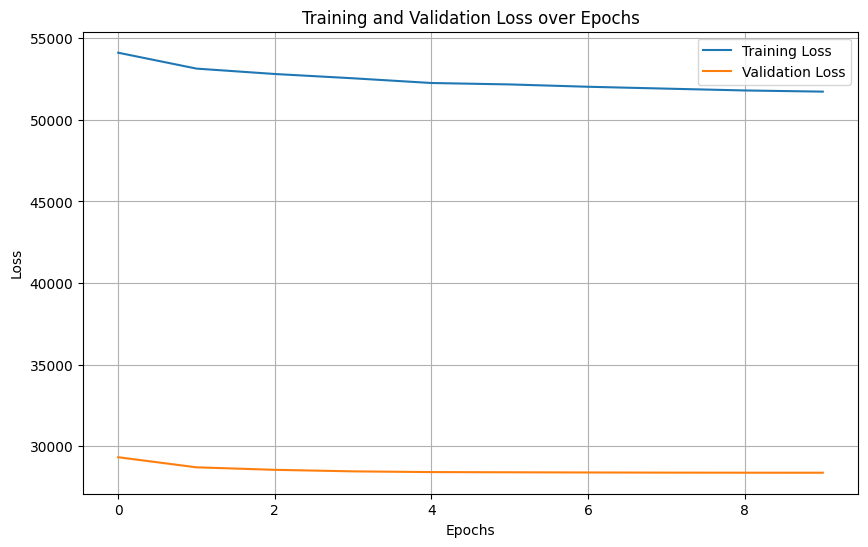

In [4]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Example: Get recommendations for a specific user ID
user_id_example = "42"  # Replace with a valid user ID from your data
recommended_movies = get_movie_recommendations(user_id_example, model, unique_movie_titles)

# Print the recommendations
print(f"Recommended Movies for User ID {user_id_example}:")
for idx, movie in enumerate(recommended_movies, 1):
    print(f"{idx}. {movie}")



Recommended Movies for User ID 42:
1. Scarlet Letter, The (1926)
2. Little Princess, The (1939)
3. 20,000 Leagues Under the Sea (1954)
4. 8 Seconds (1994)
5. Wife, The (1995)
6. Cowboy Way, The (1994)
7. Weekend at Bernie's (1989)
8. Up in Smoke (1978)
9. Hot Shots! Part Deux (1993)
10. D3: The Mighty Ducks (1996)
